## 역전파(Back-propagation) 파헤치기 2


전 포스팅 **'역전파 파헤치기 1'** 에서 필요한 사전 준비는 끝냈고, 이제 간단한 MLP 모델의 역전파를 구현해 보겠습니다. 학습용 데이터는 저번 포스팅 **'PyTorch 연습 2'** 에서 만들어 본 간단한 데이터셋을 다시 써보겠습니다.

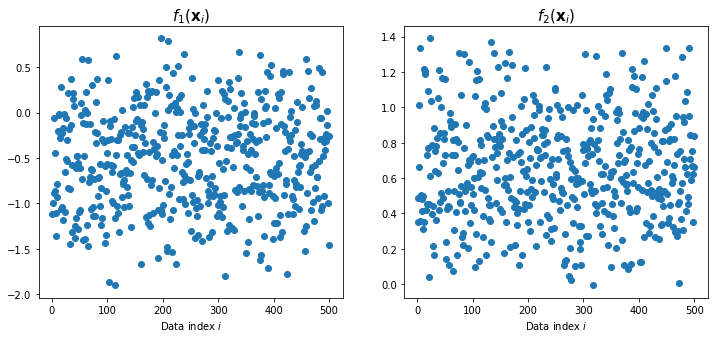

Class 0: 115 nodes
Class 1: 126 nodes
Class 2: 110 nodes
Class 3: 149 nodes
Training set: 201 nodes
Validation set: 142 nodes
Testing set: 157 nodes


In [1]:
import torch as t
import torch.nn as tnn
import torch.nn.functional as F
from math import *
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

###################### DATAFRAME CLASS #######################

class dataframe:
    def __init__(self, data_tensor,data_class, trm,vm,tm, edges=None):
      
        self.num_features = data_tensor.shape[1]
        self.num_classes = int(max(data_class).item()+1)
        self.x = data_tensor
        self.num_nodes = data_tensor.shape[0]
        self.y = data_class
        self.train_mask = trm; self.val_mask = vm; self.test_mask = tm
        
        self.edge_index = edges
        if edges == None:
            self.num_edges = [None]
        else:
            self.num_edges = edges.shape[0]

################# DATA POINT GENERATION ##################

t.manual_seed(3)
data_dim = 4
data_num = 500
data_tensor = t.rand((data_num,data_dim))

coeffs = t.randn(2,4)  # AUXILLIARY FUNCTION FOR ASSIGNING DATA CLASS
def f(x,y,z,w):        
    val1 = t.dot(coeffs[0,:], t.tensor([sin(x),cos(y),asin(z),acos(w)]))
    val2 = t.dot(coeffs[1,:], t.tensor([exp(x),exp(y),cosh(z),sinh(w)]))
    return val1, val2

y1 = t.zeros(data_num); y2 = t.zeros(data_num) 

for i in range(data_num):
    y1[i], y2[i] = f(*data_tensor[i,:])
  
fig,axes = plt.subplots(1,2)
x = t.arange(1,data_num+1)
axes[0].scatter(x,y1); axes[1].scatter(x,y2)
axes[0].set_title("$f_1(\mathbf{x}_i)$", fontsize=15); axes[1].set_title("$f_2(\mathbf{x}_i)$", fontsize=15)
axes[0].set_xlabel("Data index $i$"); axes[1].set_xlabel("Data index $i$")
fig.set_size_inches(12,5)
plt.show(fig)

############### GENERATING DATA CLASSES ################

fact1 = y1 < -0.5; fact2 = y2 < 0.6      
data_class = t.zeros(data_num,dtype=t.uint8)  
#!!! CLASS TAGS MUST BE AN INTEGER. If not, torch's loss function returns error.
for i in range(0,data_num):
    if (fact1[i] == True) and (fact2[i] == True):
        data_class[i] = 0
    elif (fact1[i] == True) and (fact2[i] == False):
        data_class[i] = 1
    elif (fact1[i] == False) and (fact2[i] == True):
        data_class[i] = 2
    else:
        data_class[i] = 3
    
print(f"Class 0: {sum(data_class == 0)} nodes")
print(f"Class 1: {sum(data_class == 1)} nodes")
print(f"Class 2: {sum(data_class == 2)} nodes")
print(f"Class 3: {sum(data_class == 3)} nodes")

######### MASKING TRAINING, VALIDATING, AND TESTING NODES #########

randvec = t.rand(data_num)    
train_mask = randvec < 0.4
test_mask = randvec > 0.7
val_mask = t.zeros(data_num, dtype=t.bool)
for i in range(data_num):
    if train_mask[i] == False and test_mask[i] == False:
        val_mask[i] = True
    else:
        val_mask[i] = False
    
print(f"Training set: {sum(train_mask)} nodes")
print(f"Validation set: {sum(val_mask)} nodes")
print(f"Testing set: {sum(test_mask)} nodes")

#data_tensor = t.remainder(data_tensor,0.5)
my_data = dataframe( data_tensor,data_class,train_mask,val_mask,test_mask)

위에 보시는 바와 같이, 저번 포스팅에서 만든 간단한 데이터셋 'my_data'는 총 500개의 데이터 포인트가 타겟 0 ~ 3까지 4개의 클래스로 분류되어 있고,
201개의 Training data, 142개의 Validating data, 157개의 Testing data로 나누어져 있습니다.

이번 포스팅에선 간단히 Training 과 Testing data만 사용하겠습니다.

In [2]:
data = my_data

보통 Torch를 사용하려면 전체 dataset 행렬을 구현할 때 하나의 데이터 point feature들을 '열'방향으로 담는데, 저는 벡터표현과 헷갈리지 않기 위해 transpose를 취해서 '행' 방향으로 표시하도록 하겠습니다.

In [3]:
x0_train = t.transpose(data.x,0,1)[:,data.train_mask]
x0_test = t.transpose(data.x,0,1)[:,data.test_mask]

또한, 현재 my_data.y 가 target class의 정보를 담아놓는 속성인데, one-hot 인코딩을 시켜 주겠습니다.

In [4]:
Y = t.zeros(data.num_classes,data.num_nodes)
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        if i == data.y[j]:
            Y[i,j] = 1
print(f"Y = \n{Y}")

Y = 
tensor([[1., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]])


이제, 두개의 레이어를 갖는 간단한 MLP 모델을 세팅해 보겠습니다.

첫 번째 레이어는 4차원 input을 8차원의 hidden channel로 바꾼 뒤 sigmoid ($\Phi(x)$) 를 취하고, 두 번째 은닉 레이어는 8차원을 4차원으로 내린 뒤 softmax ($\Psi(x)$) 를 취해 output으로 내보내도록 하겠습니다. 각 레이어 변환을 $\mathcal{L}_l$, 그것의 파라미터들 $\{\mathbf{W}_l,\mathbf{b}_l\}$ 을 $\mathbf{p}_l$ 로 놓은 뒤 수식으로 표현하면,

\begin{align}
\mathbf{x}_1 & = \mathcal{L}_0(\mathbf{x}_0;\mathbf{p}_0) = \Phi(\mathbf{W}_0\mathbf{x}_0 + \mathbf{b}_0) \\
\mathbf{x}_{\mathrm{out}} & = \mathcal{L}_1(\mathbf{x}_1;\mathbf{p}_1) = \Psi(\mathbf{W}_1\mathbf{x}_1 + \mathbf{b}_1),\qquad \mathrm{W}_0\in\mathbb{R}^{8\times 4},\;\mathrm{W}_1\in\mathbb{R}^{4\times 8},\;\mathrm{and}\; \mathrm{b}_0\in\mathbb{R}^{8},\; \mathrm{b}_1\in\mathbb{R}^{4}
\end{align}

이 되고, 이 모델은 결국 $8\times 4 + 4\times 8 + 8 + 4 = 76$개의 parameter를 갖는 아주 미니멀한 신경망 모델입니다. 먼저 모델을 임의로 initialize 시킨 후 test set에 대한 accuracy 를 구해 보면,

In [14]:
t.manual_seed(1)
W0 = t.randn(8,4); W1 = t.randn(4,8); b0 = t.randn(8); b1 = t.randn(4)

############### FORWARD MESSAGE PASSING ################

h0_test = t.matmul(W0,x0_test) + t.reshape(b0,(b0.shape[0],1))
x1_test = t.sigmoid(h0_test)
h1_test = t.matmul(W1,x1_test) + t.reshape(b1,(b1.shape[0],1))
xout_test = t.softmax(h1_test,dim=0)

########################################################

pred_test = xout_test.argmax(dim=0)
test_correct = pred_test == data.y[data.test_mask]
test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2484


정확도가 1/4인 25퍼센트에도 못 미치는, 전혀 분류를 하지 못하는 모습을 보입니다.

이제 직접 training 루틴을 짜 보겠습니다.

각 레이어의 activation을 취하기 전의 output $\mathbf{W}_l\mathbf{x}_l + \mathbf{b}_l$ 을 $\mathbf{h}_l$ 로 표기하면, 역전파에 필요한 도함수 텐서들은 다음과 같습니다 (편의상 레이어 인덱스 $l$은 생략했고, $\phi$는 스칼라 sigmoid 함수를 뜻합니다):

\begin{align}
\left(\frac{\partial}{\partial\mathbf{h}}\Phi(\mathbf{h})\right)^i_j & = \phi(h^i)(1-\phi(h^i))\delta^i_j \quad\cdots\;\mathrm{(A)} \\
\left(\frac{\partial\mathbf{h}}{\partial\mathbf{x}}\right)^i_j & = W^i_j \quad\cdots\;\mathrm{(B)}\\
\left(\frac{\partial\mathbf{h}}{\partial\mathbf{W}}\right)^i_{j,k} & = \delta^i_j x_k \quad\cdots\;\mathrm{(C)}\\
\left(\frac{\partial\mathbf{h}}{\partial\mathbf{b}}\right)^i_j & = \delta^i_j \quad\cdots\;\mathrm{(D)}
\end{align}

필요한 정보들을 받아 위 도함수 텐서들을 구현하는 루틴을 만들어 보면, 위에서부터 아래로 다음과 같이 짤 수 있습니다.

In [6]:
def get_dL_dh(h): ######################################## GET (A)
    dphi_dh = t.zeros(h.shape[0],h.shape[0],h.shape[1])
    for i in range(dphi_dh.shape[0]):
        for k in range(dphi_dh.shape[2]):
            phiprime = t.sigmoid(h[:,k]) * (t.ones(h.shape[0]) - t.sigmoid(h[:,k]))
            dphi_dh[i,i,k] = phiprime[i]
    return dphi_dh

def get_dh_dx(h,x,W): #################################### GET (B)
    dh_dx = t.zeros(h.shape[0],x.shape[0],x.shape[1])
    for k in range(dh_dx.shape[2]):
        dh_dx[:,:,k] = W
    return dh_dx
  
def get_dh_dW(h,x,W): #################################### GET (C)
    dh_dW = t.zeros(h.shape[0],W.shape[0],W.shape[1],x.shape[1])
    for i in range(dh_dW.shape[0]):
        for k in range(dh_dW.shape[3]):
            dh_dW[i,i,:,k] = x[:,k]
    return dh_dW

def get_dh_db(h,x,W): #################################### GET (D)
    dh_db = t.zeros(h.shape[0],h.shape[0],x.shape[1])
    for k in range(dh_db.shape[2]):
        dh_db[:,:,k] = t.eye(h.shape[0])
    return dh_db

아직 softmax의 도함수는 구하지 않았습니다. 왜냐하면, Loss로 Cross Entropy를 사용하게 되면, 두번째 레이어의 softmax output에 대해 도함수를 구할 때 division by 0 문제가 발생합니다. 따라서, 크로스 엔트로피의 도함수는 softmax 함수 $\Psi$를 취하기 전의 변수인 $\mathbf{h}_1$ 에 대해 구해야 division by 0 문제를 피할 수 있게 되며, 수식으로도 훨씬 간단히

$$ \frac{\partial}{\partial\mathbf{h}} \mathrm{CEloss}(\Psi(\mathbf{h});\mathbf{y})  = \mathrm{y}-\mathrm{h}$$

로 표현되어 역전파가 더욱 안정적으로 이루어지게 됩니다. 코드로는 간단히 다음과 같습니다.

In [7]:
def get_dLoss_dh(h,Y,N):
    return Y-h

이제, [참고자료](https://github.com/hkyoon94/ML)에 계산해 놓은 일반적 $L+1$개 레이어에 대한 역전파 식을 바탕으로, 이 간단한 2-레이어 MLP의 역전파는 다음 두 가지만 계산해주면 됩니다:

\begin{align}
  \frac{\partial}{\partial\mathbf{p}_1}\mathbf{x}_{\mathrm{out}} & = \frac{\partial\mathcal{L}_1(\mathbf{x}_1;\mathbf{p}_1) }{\partial\mathbf{p}_1} \\
  & = \frac{\partial}{\partial\mathbf{h_1}}\Psi(\mathbf{h_1})\;\frac{\partial}{\partial \mathbf{p_1}}\mathbf{h}_1(\mathbf{x}_1;\mathbf{p}_1), \quad\cdots\;\mathrm{(E)} \\
  \frac{\partial}{\partial\mathbf{p}_{0}}\mathbf{x}_{\mathrm{out}} & = \frac{\partial\mathcal{L}_1(\mathbf{x}_1;\mathbf{p}_1) }{\partial\mathbf{x}_1}\frac{\partial\mathcal{L}_{0}(\mathbf{x}_{0};\mathbf{p}_{0}) }{\partial\mathbf{p}_{0}} \\
  & =\frac{\partial}{\partial\mathbf{h_1}}\Psi(\mathbf{h_1})\;\frac{\partial}{\partial \mathbf{x_1}}\mathbf{h}_1(\mathbf{x}_1;\mathbf{p}_1)\;\frac{\partial}{\partial\mathbf{h_0}}\Phi(\mathbf{h_0})\;\frac{\partial}{\partial \mathbf{p_0}}\mathbf{h}_0(\mathbf{x}_0;\mathbf{p}_0). \quad\cdots\;\mathrm{(F)}\\
\end{align}

**(도함수 표기 사이의 연산은 텐서 수축임을 잊지 맙시다)** 이제 위를 바탕으로 체인 룰을 torch.tensordot()을 이용해 계산해 주며 역전파 학습을 시작해 보겠습니다.

**물론, 현대에는 널리 알려진, 과적합 방지용 mini-batch 학습을 통한 Stochastic 경사하강법, dropout 등이 아무것도 없는, 전체 데이터셋을 한꺼번에 넣고 한꺼번에 업데이트를 하는 '깡통' 경사하강법입니다. 최적화나, 과적합 등은 고려하지 않은(아직 고려할 만한 코딩실력도 없습니다...) 루틴입니다.**

Epoch당 크로스 엔트로피 손실 함숫값을 뽑아 내도록 했습니다.

In [16]:
################## TRAINING NETWORK ##################

epochs = range(201); 
train_loss = t.zeros(len(epochs)); test_loss = t.zeros(len(epochs))
train_acc = t.zeros(len(epochs)); test_acc = t.zeros(len(epochs))


for epoch in epochs:
  
  
    ############### FORWARD MESSAGE PASSING ################

    h0 = t.matmul(W0,x0_train) + t.reshape(b0,(b0.shape[0],1))
    h0_test = t.matmul(W0,x0_test) + t.reshape(b0,(b0.shape[0],1))
    x1 = t.sigmoid(h0)
    x1_test = t.sigmoid(h0_test)
    
    dL0_dh0 = get_dL_dh(h0)             # SAVE (A) FOR GRAD
    dh0_dW0 = get_dh_dW(h0,x0_train,W0) # SAVE (C) FOR GRAD
    dh0_db0 = get_dh_db(h0,x0_train,W0) # SAVE (D) FOR GRAD

    h1 = t.matmul(W1,x1) + t.reshape(b1,(b1.shape[0],1))
    h1_test = t.matmul(W1,x1_test) + t.reshape(b1,(b1.shape[0],1))
    xout_train = t.softmax(h1, dim=0)
    xout_test = t.softmax(h1_test, dim=0)
    
    dL1_dh1 = get_dL_dh(h1)             # SAVE (A) FOR GRAD
    dh1_dx1 = get_dh_dx(h1,x1,W1)       # SAVE (B) FOR GRAD
    dh1_dW1 = get_dh_dW(h1,x1,W1)       # SAVE (C) FOR GRAD
    dh1_db1 = get_dh_db(h1,x1,W1)       # SAVE (D) FOR GRAD


    ################ LOSS & ACCURACY EVALUATION ################

    train_loss[epoch] = t.tensordot(-t.log(xout_train),Y[:,data.train_mask])/sum(data.train_mask) # GET CELOSS
    test_loss[epoch] = t.tensordot(-t.log(xout_test),Y[:,data.test_mask])/sum(data.test_mask)
    print(f"In epoch: {epoch}, Loss = {train_loss[epoch]:.4f}")
    
    pred_train = xout_train.argmax(dim=0)
    pred_test = xout_test.argmax(dim=0)
    train_correct = pred_train == data.y[data.train_mask]
    test_correct = pred_test == data.y[data.test_mask]
    train_acc[epoch] = int(train_correct.sum()) / int(data.train_mask.sum())
    test_acc[epoch] = int(test_correct.sum()) / int(data.test_mask.sum())
    
    dLoss_dh1 = get_dLoss_dh(xout_train,Y[:,data.train_mask],x0_train.shape[1]) # GET LOSS GRAD
    
    
    ################## BACK PROPAGATION ###################
    
    dh1_dW0 = t.zeros(h1.shape[0],W0.shape[0],W0.shape[1],h1.shape[1]) #### COMPUTING (E),(F)
    dh1_db0 = t.zeros(h1.shape[0],b0.shape[0],h1.shape[1])
    
    for k in range(x0_train.shape[1]):
        dh1_dW0[:,:,:,k] = t.tensordot( dh1_dx1[:,:,k], 
                          t.tensordot(dL0_dh0[:,:,k],dh0_dW0[:,:,:,k],dims=[[1],[0]]), dims=[[1],[0]])
        dh1_db0[:,:,k] = t.tensordot( dh1_dx1[:,:,k], 
                        t.tensordot(dL0_dh0[:,:,k],dh0_db0[:,:,k],dims=[[1],[0]]), dims=[[1],[0]]) 
      
    dLoss_dW1 = t.tensordot(dLoss_dh1,dh1_dW1, dims=[[0,1],[0,3]]) #### COMPUTING LOSS DERIVATIVE
    dLoss_dW0 = t.tensordot(dLoss_dh1,dh1_dW0, dims=[[0,1],[0,3]])
    dLoss_db1 = t.tensordot(dLoss_dh1,dh1_db1, dims=[[0,1],[0,2]])
    dLoss_db0 = t.tensordot(dLoss_dh1,dh1_db0, dims=[[0,1],[0,2]])


    ################ PARAMETER UPDATING #################

    lr = 0.01
    W1 = W1 + lr * dLoss_dW1    # PERFORM STEEPEST DESCENT
    W0 = W0 + lr * dLoss_dW0
    b1 = b1 + lr * dLoss_db1
    b0 = b0 + lr * dLoss_db0
  
print("\n################ LEARNING FINISHED! ################\n")

In epoch: 0, Loss = 5.3082
In epoch: 1, Loss = 3.8433
In epoch: 2, Loss = 2.8140
In epoch: 3, Loss = 2.3637
In epoch: 4, Loss = 2.0939
In epoch: 5, Loss = 1.9062
In epoch: 6, Loss = 1.7545
In epoch: 7, Loss = 1.6238
In epoch: 8, Loss = 1.5184
In epoch: 9, Loss = 1.4445
In epoch: 10, Loss = 1.4021
In epoch: 11, Loss = 1.3824
In epoch: 12, Loss = 1.3749
In epoch: 13, Loss = 1.3722
In epoch: 14, Loss = 1.3709
In epoch: 15, Loss = 1.3701
In epoch: 16, Loss = 1.3694
In epoch: 17, Loss = 1.3686
In epoch: 18, Loss = 1.3677
In epoch: 19, Loss = 1.3668
In epoch: 20, Loss = 1.3657
In epoch: 21, Loss = 1.3645
In epoch: 22, Loss = 1.3632
In epoch: 23, Loss = 1.3616
In epoch: 24, Loss = 1.3599
In epoch: 25, Loss = 1.3579
In epoch: 26, Loss = 1.3555
In epoch: 27, Loss = 1.3528
In epoch: 28, Loss = 1.3496
In epoch: 29, Loss = 1.3458
In epoch: 30, Loss = 1.3412
In epoch: 31, Loss = 1.3358
In epoch: 32, Loss = 1.3293
In epoch: 33, Loss = 1.3215
In epoch: 34, Loss = 1.3121
In epoch: 35, Loss = 1.3011
In

Loss 값이 0.1 근처까지 떨어졌습니다. 이 정도면 꽤 러닝이 잘 된 것 같습니다.

이제 Test set에 대한 정확도를 다시 구해보고, Loss 값과 정확도가 학습 과정 중 어떤 양상을 보였는지 확인해 보겠습니다.

Test Accuracy: 0.9554


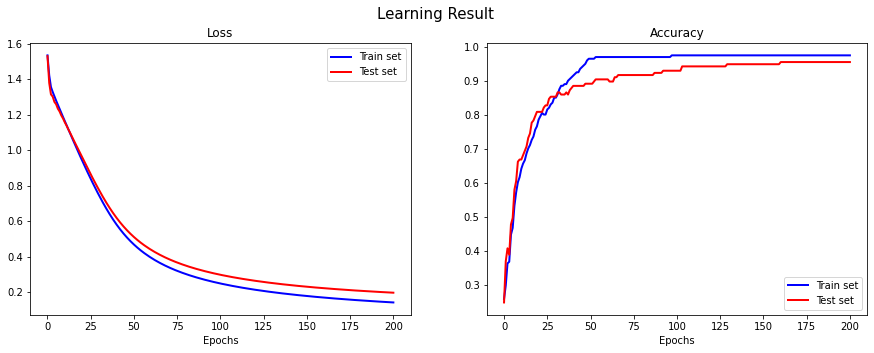

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


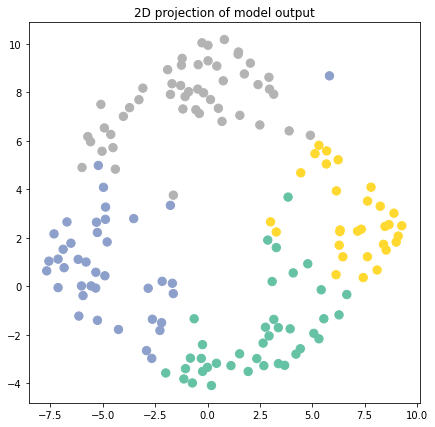

In [9]:
############### VISUALIZING ################

print(f"Test Accuracy: {test_acc[-1]:.4f}")

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
fig.suptitle("Learning Result", fontsize = 15)

loss1, = ax[0].plot( epochs, train_loss, color='b', linewidth=2 , label = "Train set")
loss3, = ax[0].plot( epochs, test_loss, color='r', linewidth=2, label = "Test set" )
ax[0].legend(handles = [loss1, loss3])
ax[0].set_xlabel("Epochs")
ax[0].set_title("Loss")

acc1, = ax[1].plot( epochs, train_acc, color='b', linewidth=2, label = "Train set")
acc3, = ax[1].plot( epochs, test_acc, color='r', linewidth=2, label = "Test set" )
ax[1].legend(handles = [acc1, acc3])
ax[1].set_xlabel("Epochs")
ax[1].set_title("Accuracy")
plt.show()

z = TSNE(n_components=2).fit_transform(t.transpose(h1_test,0,1).detach().cpu().numpy())
fig,ax = plt.subplots()
fig.set_size_inches(7,7)
ax.set_title('2D projection of model output',fontsize=12)
ax.scatter(z[:,0], z[:,1], s=70, c=data.y[data.test_mask], cmap="Set2")
plt.show()

정확도도 0.25 수준에서 0.95 이상까지 꽤나 빨리 높아지고, Output의 TSNE 플롯도 꽤 4개의 클래스로 분류가 잘 되어있는 것을 볼 수 있습니다. 이 정도면 만족스런 결과가 나왔습니다.

## PyTorch의 Adam 옵티마이저와 비교해보기

이젠, 제 루틴이 현대까지 수많은 엔지니어들이 몇 년에 걸쳐 갈고 닦아 놓은 Torch의 대표적인 옵티마이저와 비교했을 때 얼마나 성능이 떨어지고, 최적화가 비효율적이어서 느린지도 비교해 보겠습니다. 

먼저, 기존 연습 때 짜 두었던 학습용 루틴과 시각화 루틴을 불러오고,

In [10]:
################ CLASS OF FEED-FORWARD NEURAL NETS ################

class FFNN(t.nn.Module):
    def __init__(self, layers, activations, hidden_channels, data, 
                layer_options=False, fw_options=False, dropouts=False):
        super(FFNN,self).__init__()
        t.manual_seed(1)
        
        self.data = data
        self.activations = activations
        self.fw_options = fw_options
        self.dropouts = dropouts
        self.num_layers = len(layers)
        
        if layer_options == False:
            self.layer_options = [[] for i in range(self.num_layers)]
        if fw_options == False:
            self.fw_options = [[] for i in range(self.num_layers)]
          
        self.channels = hidden_channels
        self.channels.insert(0,self.data.num_features); 
        self.channels.append(self.data.num_classes)
        
        self.layers = [ ]
        for i in range(0,self.num_layers):
            args = [self.channels[i],self.channels[i+1]]; args.extend(self.layer_options[i])
            self.layers.append( layers[i]( *args ) )
        self.layers = t.nn.ModuleList(self.layers)
      
    def forward(self, x):
        for i in range(0,self.num_layers):
            args = [x]; args.extend(self.fw_options[i])
            x = self.activations[i]( self.layers[i]( *args ))
            if self.dropouts is not False:
                x = F.dropout(x, p=self.dropouts[i], training=self.training)
            else:
                pass
        return x

################ LEARNING & TESTING ROUTINE #################

class learn:
    def __init__(self, model, optimizer, criterion, epochs, data):
      
        self.data = data
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = t.arange(1,epochs+1)
        loss_vec = t.zeros((3,epochs)); acc_vec = t.zeros((3,epochs))
        
        for epoch in range(0,epochs):
            loss_vec[:,epoch], self.out = self.train_onestep()
            acc_vec[:,epoch] = self.get_accuracy(self.out)
      
        print("\n############################## LEARNING FINISHED! ##################################\n")
        
        self.train_loss = loss_vec[0,:]; self.train_acc = acc_vec[0,:]
        self.val_loss = loss_vec[1,:]; self.val_acc = acc_vec[1,:]
        self.test_loss = loss_vec[2,:]; self.test_acc = acc_vec[2,:]
        
        print(f'Test Accuracy: {self.test_acc[-1]:.4f}')
      
    def train_onestep(self):
      
        self.model.train()
        self.optimizer.zero_grad()
        out = self.model.forward(self.data.x)
        
        train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        val_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
        test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
        train_loss.backward() 
        self.optimizer.step()  
        
        return t.tensor([train_loss, val_loss, test_loss]), out
    
    def get_accuracy(self,out):
      
        self.model.eval()
        pred = out.argmax(dim=1) 
        
        train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
        val_correct = pred[self.data.val_mask] == self.data.y[self.data.val_mask]
        test_correct = pred[self.data.test_mask] == self.data.y[self.data.test_mask]
        
        train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
        val_acc = int(val_correct.sum()) / int(self.data.val_mask.sum())
        test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
        
        return t.tensor([train_acc, val_acc, test_acc])
    
  ############### VISUALIZING ROUTINE ################

    def visualize(result, progress_plot=True, TSNE_plot=False):

      if progress_plot is True:
          fig, ax = plt.subplots(1,2)
          fig.set_size_inches(15,5)
          fig.suptitle("Learning Result", fontsize = 15)
          
          loss1, = ax[0].plot( result.epochs, result.train_loss, color='b', linewidth=2 , label = "Train set")
          loss3, = ax[0].plot( result.epochs, result.test_loss, color='r', linewidth=2, label = "Test set" )
          ax[0].legend(handles = [loss1, loss3])
          ax[0].set_xlabel("Epochs")
          ax[0].set_title("Loss")

          acc1, = ax[1].plot( result.epochs, result.train_acc, color='b', linewidth=2, label = "Train set")
          acc3, = ax[1].plot( result.epochs, result.test_acc, color='r', linewidth=2, label = "Test set" )
          ax[1].legend(handles = [loss1, loss3])
          ax[1].set_xlabel("Epochs")
          ax[1].set_title("Accuracy")
          plt.show()
      else:
          pass
      
      if TSNE_plot is True:
          z = TSNE(n_components=2).fit_transform(result.out[result.data.test_mask].detach().cpu().numpy())
          fig,ax = plt.subplots()
          fig.set_size_inches(7,7)
          ax.set_title('2D projection of model output',fontsize=12)
          ax.scatter(z[:,0], z[:,1], s=70, c=result.data.y[result.data.test_mask], cmap="Set2")
          plt.show()
      else:
          pass

제가 짰던 2-레이어 MLP 모델과 완전히 똑같은 모델을 만들어 학습을 해 보겠습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.9554


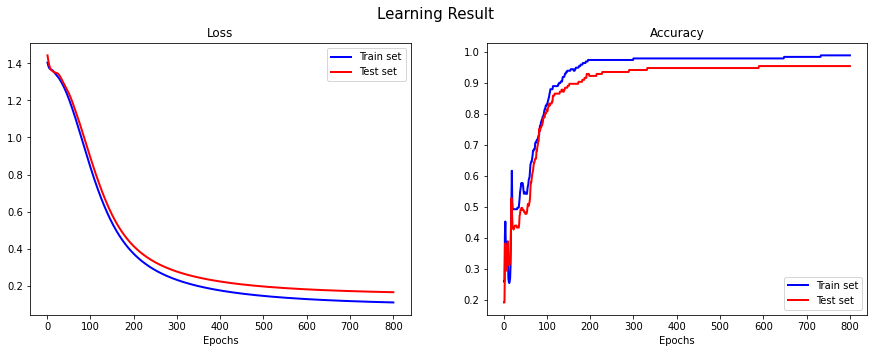

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


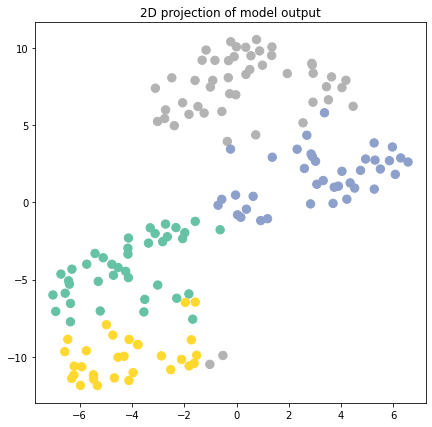

In [11]:
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ t.sigmoid, t.nn.Identity() ],
            hidden_channels = [ 8 ],
            data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 800,
                data = data)

visualize(result,TSNE_plot=True)

Adam 옵티마이저도 Loss 값을 거의 0.1까지 내렸고, 성능 면에서도 같은 정확도인 0.9554를 내는 것을 보아 성능 면에서는(?) 거의 비슷한 결과를 보임을 알 수 있습니다.

***그러나, 제 깡통 경사하강법 루틴은 5세대(...) i5 CPU 싱글코어 상에서 35초 정도 학습에 걸린 반면, 사실 Adam 옵티마이저는 1.5초면 학습을 마칩니다. 정말 속도 면에서는 어마어마한 차이를 보였습니다!*** CUDA 세팅이 되어 있긴 한데, 따로 지시를 해 주지 않으면 GPU는 쓰지 않는 것으로 알고 있는데(아닌가요?)... 이렇게 속도 차이가 날 줄은 몰랐습니다. 여튼 PyTorch의 내장 루틴이 얼마나 최적화가 잘 되어있고, 얼마나 강력한지 새삼 깨닫게 되었습니다.

이젠 마지막으로, Adam optimizer로도 학습이 잘 안 되었던, torch.remainder()함수를 이용해 데이터셋을 한 번 비틀어버린 데이터를 이용해 같은 모델로 다시 학습을 해 보겠습니다.

In [17]:
data_tensor = t.remainder(data_tensor,0.5)
setattr(my_data,"x",data_tensor)
data = my_data

x0_train = t.transpose(data.x,0,1)[:,data.train_mask]
x0_test = t.transpose(data.x,0,1)[:,data.test_mask]

t.manual_seed(1)
W0 = t.randn(8,4); W1 = t.randn(4,8); b0 = t.randn(8); b1 = t.randn(4)

################## TRAINING NETWORK ##################

epochs = range(201); 
train_loss = t.zeros(len(epochs)); test_loss = t.zeros(len(epochs))
train_acc = t.zeros(len(epochs)); test_acc = t.zeros(len(epochs))

for epoch in epochs:
    ############### FORWARD MESSAGE PASSING ################

    h0 = t.matmul(W0,x0_train) + t.reshape(b0,(b0.shape[0],1))
    h0_test = t.matmul(W0,x0_test) + t.reshape(b0,(b0.shape[0],1))
    x1 = t.sigmoid(h0)
    x1_test = t.sigmoid(h0_test)
    
    dL0_dh0 = get_dL_dh(h0) # RECORDING FOR GRAD
    dh0_dW0 = get_dh_dW(h0,x0_train,W0) 
    dh0_db0 = get_dh_db(h0,x0_train,W0)

    h1 = t.matmul(W1,x1) + t.reshape(b1,(b1.shape[0],1))
    h1_test = t.matmul(W1,x1_test) + t.reshape(b1,(b1.shape[0],1))
    xout_train = t.softmax(h1, dim=0)
    xout_test = t.softmax(h1_test, dim=0)
    
    dL1_dh1 = get_dL_dh(h1) # RECORDING FOR GRAD
    dh1_dx1 = get_dh_dx(h1,x1,W1)
    dh1_dW1 = get_dh_dW(h1,x1,W1) 
    dh1_db1 = get_dh_db(h1,x1,W1)

    ################ LOSS & ACCURACY EVALUATION ################

    train_loss[epoch] = t.tensordot(-t.log(xout_train),Y[:,data.train_mask])/sum(data.train_mask)
    test_loss[epoch] = t.tensordot(-t.log(xout_test),Y[:,data.test_mask])/sum(data.test_mask)
    print(f"In epoch: {epoch}, Loss = {train_loss[epoch]:.4f}")
    
    pred_train = xout_train.argmax(dim=0)
    pred_test = xout_test.argmax(dim=0)
    train_correct = pred_train == data.y[data.train_mask]
    test_correct = pred_test == data.y[data.test_mask]
    train_acc[epoch] = int(train_correct.sum()) / int(data.train_mask.sum())
    test_acc[epoch] = int(test_correct.sum()) / int(data.test_mask.sum())
    
    dLoss_dh1 = get_dLoss_dh(xout_train,Y[:,data.train_mask],x0_train.shape[1]) # RECORDING FOR GRAD
    
    ################## BACK PROPAGATION ###################
    
    dh1_dW0 = t.zeros(h1.shape[0],W0.shape[0],W0.shape[1],h1.shape[1])
    dh1_db0 = t.zeros(h1.shape[0],b0.shape[0],h1.shape[1])
    
    for k in range(x0_train.shape[1]):
        dh1_dW0[:,:,:,k] = t.tensordot( dh1_dx1[:,:,k], 
                          t.tensordot(dL0_dh0[:,:,k],dh0_dW0[:,:,:,k],dims=[[1],[0]]), dims=[[1],[0]])
        dh1_db0[:,:,k] = t.tensordot( dh1_dx1[:,:,k], 
                        t.tensordot(dL0_dh0[:,:,k],dh0_db0[:,:,k],dims=[[1],[0]]), dims=[[1],[0]])
      
    dLoss_dW1 = t.tensordot(dLoss_dh1,dh1_dW1, dims=[[0,1],[0,3]])
    dLoss_dW0 = t.tensordot(dLoss_dh1,dh1_dW0, dims=[[0,1],[0,3]])
    dLoss_db1 = t.tensordot(dLoss_dh1,dh1_db1, dims=[[0,1],[0,2]])
    dLoss_db0 = t.tensordot(dLoss_dh1,dh1_db0, dims=[[0,1],[0,2]])

    ################ PARAMETER UPDATING #################

    lr = 0.01
    W1 = W1 + lr * dLoss_dW1
    W0 = W0 + lr * dLoss_dW0
    b1 = b1 + lr * dLoss_db1
    b0 = b0 + lr * dLoss_db0
  
print("\n################ LEARNING FINISHED! ################\n")

In epoch: 0, Loss = 1.5581
In epoch: 1, Loss = 1.4552
In epoch: 2, Loss = 1.4001
In epoch: 3, Loss = 1.3958
In epoch: 4, Loss = 1.3930
In epoch: 5, Loss = 1.3907
In epoch: 6, Loss = 1.3886
In epoch: 7, Loss = 1.3867
In epoch: 8, Loss = 1.3848
In epoch: 9, Loss = 1.3829
In epoch: 10, Loss = 1.3811
In epoch: 11, Loss = 1.3793
In epoch: 12, Loss = 1.3776
In epoch: 13, Loss = 1.3759
In epoch: 14, Loss = 1.3742
In epoch: 15, Loss = 1.3725
In epoch: 16, Loss = 1.3709
In epoch: 17, Loss = 1.3693
In epoch: 18, Loss = 1.3678
In epoch: 19, Loss = 1.3662
In epoch: 20, Loss = 1.3647
In epoch: 21, Loss = 1.3631
In epoch: 22, Loss = 1.3616
In epoch: 23, Loss = 1.3601
In epoch: 24, Loss = 1.3587
In epoch: 25, Loss = 1.3572
In epoch: 26, Loss = 1.3558
In epoch: 27, Loss = 1.3543
In epoch: 28, Loss = 1.3529
In epoch: 29, Loss = 1.3515
In epoch: 30, Loss = 1.3501
In epoch: 31, Loss = 1.3487
In epoch: 32, Loss = 1.3473
In epoch: 33, Loss = 1.3459
In epoch: 34, Loss = 1.3445
In epoch: 35, Loss = 1.3431
In

아까보다는 Loss가 현저히 느리게 감소하는 것을 볼 수 있습니다. 정확도 측정과 학습과정 시각화를 해보면:

Test Accuracy: 0.3822


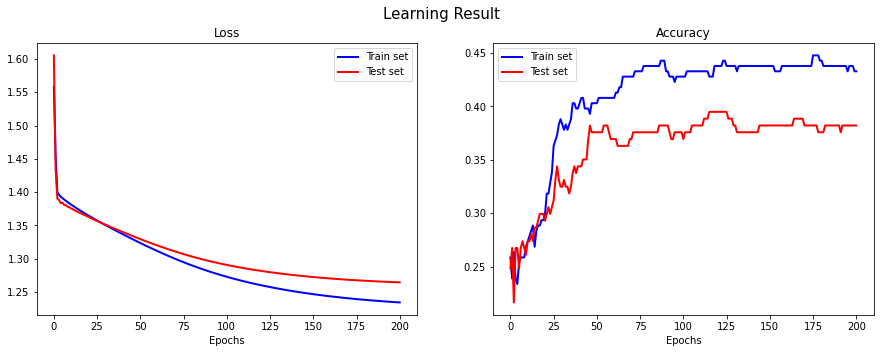

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


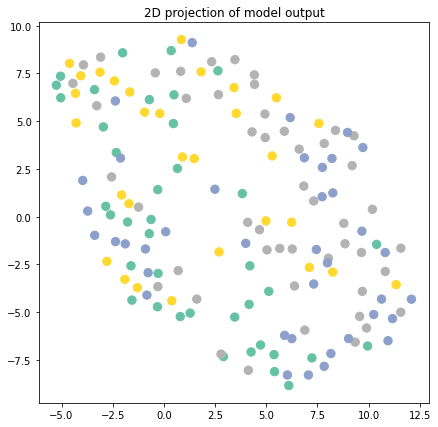

In [18]:
############### VISUALIZING ################

print(f"Test Accuracy: {test_acc[-1]:.4f}")

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
fig.suptitle("Learning Result", fontsize = 15)

loss1, = ax[0].plot( epochs, train_loss, color='b', linewidth=2 , label = "Train set")
loss3, = ax[0].plot( epochs, test_loss, color='r', linewidth=2, label = "Test set" )
ax[0].legend(handles = [loss1, loss3])
ax[0].set_xlabel("Epochs")
ax[0].set_title("Loss")

acc1, = ax[1].plot( epochs, train_acc, color='b', linewidth=2, label = "Train set")
acc3, = ax[1].plot( epochs, test_acc, color='r', linewidth=2, label = "Test set" )
ax[1].legend(handles = [acc1, acc3])
ax[1].set_xlabel("Epochs")
ax[1].set_title("Accuracy")
plt.show()

z = TSNE(n_components=2).fit_transform(t.transpose(h1_test,0,1).detach().cpu().numpy())
fig,ax = plt.subplots()
fig.set_size_inches(7,7)
ax.set_title('2D projection of model output',fontsize=12)
ax.scatter(z[:,0], z[:,1], s=70, c=data.y[data.test_mask], cmap="Set2")
plt.show()

학습이 거의 안 되는 수준이고, Loss값의 플롯을 보면 작은 모델이라 피팅에 한계가 있는 것 같습니다.

사실 이건 저번에도 Adam 옵티마이저도 제 힘을 발휘를 못 하는 걸 확인 했었는데요, 다시 한 번 보겠습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4268


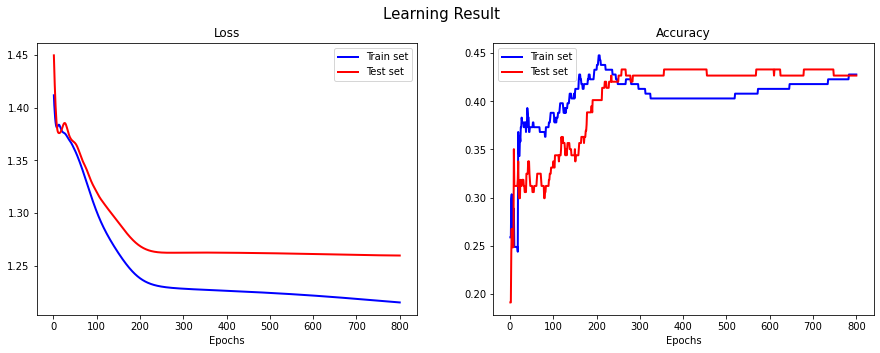

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


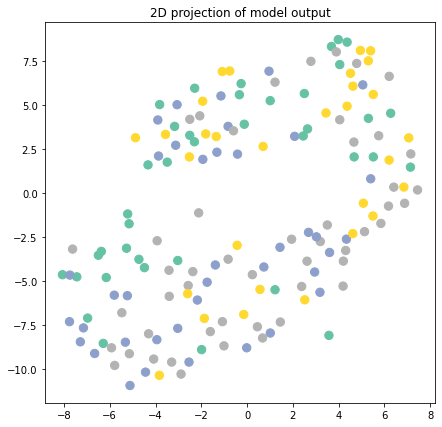

In [19]:
data = my_data
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ t.sigmoid, t.nn.Identity() ],
            hidden_channels = [ 8 ],
            data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 800,
                data = data)

visualize(result,TSNE_plot=True)

정확도는 제 루틴보다 살짝 낫지만 이것도 학습이 되었다고는 할 수 없는 수준입니다. **역시 데이터셋의 feature를 강하게 비틀어 놓으면, 단순한 모델로는 러닝이 잘 안되는 것 같습니다.**

## 결론

* 어디까지나 제 궁금증 때문에 해 본 작은 프로젝트지만, minibatch 학습법, dropout 등을 모조리 뺀, 우직한 순정(?) 경사하강법을 이용해 역전파를 짜도 좋은 데이터셋에 대해서는 학습이 잘 되긴 하는 걸 확인했습니다. ***하지만, 최적화 수준으로 보나, 성능으로 보나, 굳이 그럴 이유는 역시나 절대 없다는 걸 확실히 깨달을 수 있었습니다!***
* 작은 모델은 일관적이지 않은 feature들을 갖는 데이터셋에 대해선 분류 능력이 한계가 있는 것이 맞는 것 같습니다.

이제야 드디어 앞서 미뤄 두었던, 진짜 현실의 raw 데이터를 활용한 러닝을 제대로 연습을 시작해봐도 될 것 같습니다. 또, Validating set을 이용한 stopping criterion 설계와 등도 포함 좀 더 실용적인 스킬을 익히는 데에 집중해 보겠습니다.